## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Data Preparation

In [2]:
# Define dataset directories
train_dir = "../Dataset for CA1 part A - AY2526S1/train"
val_dir = "../Dataset for CA1 part A - AY2526S1/validation"
test_dir = "../Dataset for CA1 part A - AY2526S1/test"

In [3]:
# Create a function to load the dataset, convert it to grayscale and resize it to the target size
def load_dataset(data_dir, target_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),  # Load original size first
        batch_size=32,
        label_mode="int",  # or 'categorical' if needed
        shuffle=True,
    )

    # Convert RGB to grayscale and resize to target size
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        return image, label

    dataset = dataset.map(preprocess)
    return dataset

In [4]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [5]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 253.95288)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 254.24814)
Class names not available in dataset object


23x23 Samples:


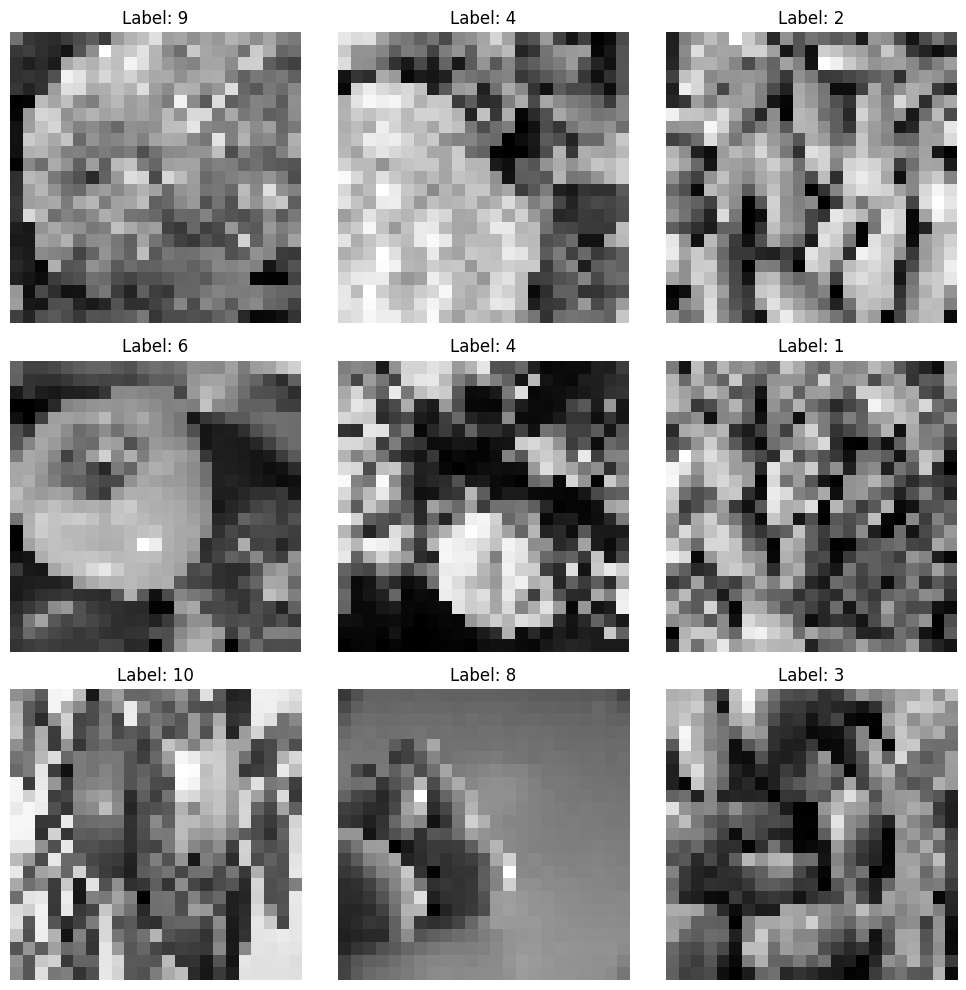


101x101 Samples:


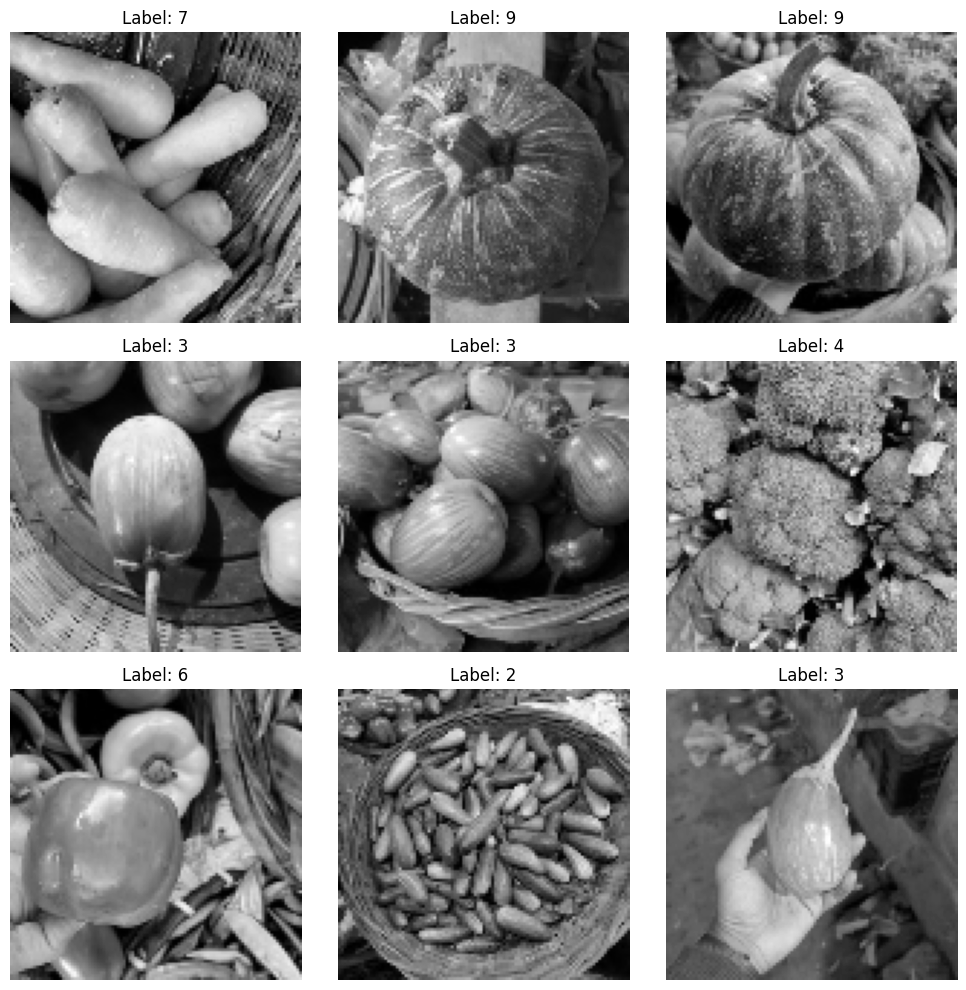

In [6]:
# View the first 9 samples of the training set
def show_samples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(n, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()


print("23x23 Samples:")
show_samples(train_23)

print("\n101x101 Samples:")
show_samples(train_101)

In [7]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)

Found 7699 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [8]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print(f"Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.9745

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 253.7724


## Fully Connected Model (Baseline)


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 5s 14ms/step - loss: 12.6088 - accuracy: 0.1160 - val_loss: 2.4059 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3657 - accuracy: 0.1227 - val_loss: 2.4174 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3579 - accuracy: 0.1273 - val_loss: 2.4282 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3515 - accuracy: 0.1248 - val_loss: 2.4360 - val_accuracy: 0.0905
Epoch 5/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3502 - accuracy: 0.1277 - val_loss: 2.4418 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3494 - accuracy: 0.1251 - val_loss: 2.4452 - val_accuracy: 0.0909


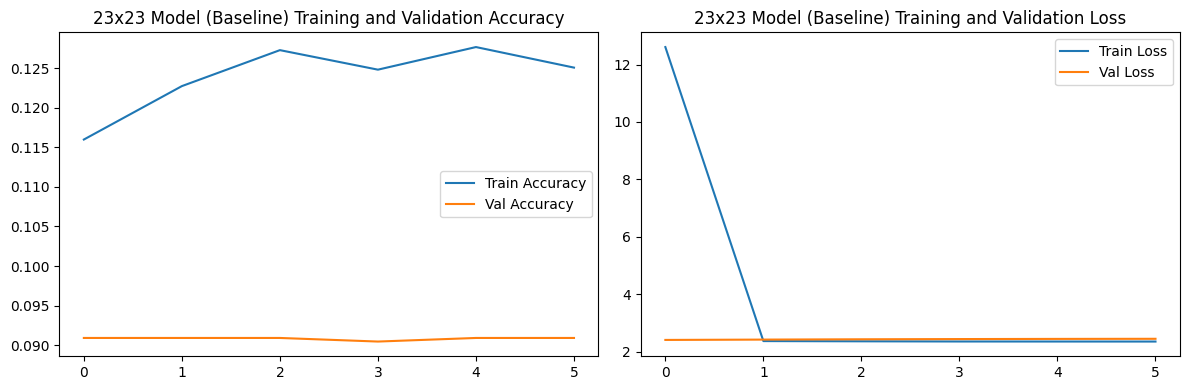

69/69 [==============================] - 1s 11ms/step - loss: 2.4433 - accuracy: 0.0914
23x23 Model (Baseline) - Test Accuracy: 0.0914
23x23 Model (Baseline) - Test Loss: 2.4433

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 4s 16ms/step - loss: 31.4686 - accuracy: 0.1198 - val_loss: 2.4035 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3667 - accuracy: 0.1174 - val_loss: 2.4130 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3574 - accuracy: 0.1157 - val_loss: 2.4225 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3525 - accuracy: 0.1200 - val_loss: 2.4308 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 4s 16ms/step - loss: 2.3511 - accuracy: 0.1216 - val_loss: 2.4361 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 4s 16ms/step -

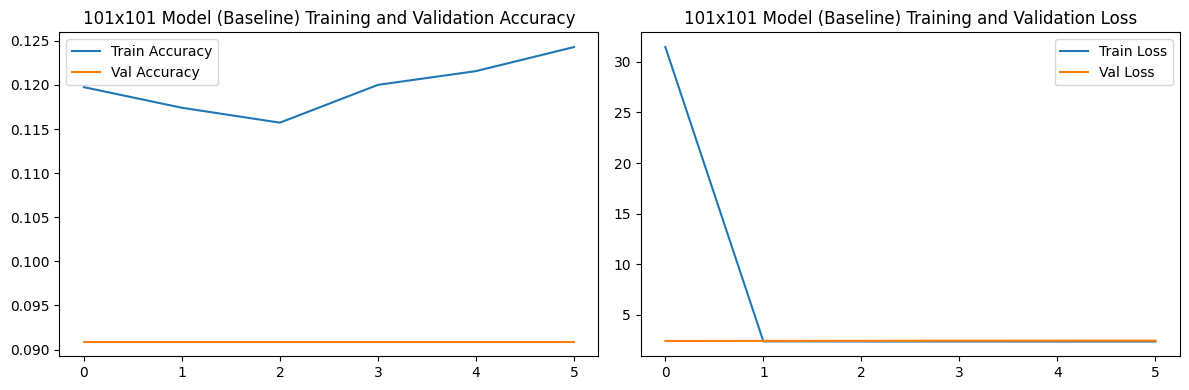

69/69 [==============================] - 1s 11ms/step - loss: 2.4406 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4406


In [9]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


# Example usage:

# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")


## Training CNN Models

In [10]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [11]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping, checkpoint],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...
Epoch 1/50
241/241 [==============================] - 8s 18ms/step - loss: 2.8254 - accuracy: 0.1421 - val_loss: 2.2466 - val_accuracy: 0.1859
Epoch 2/50
241/241 [==============================] - 4s 18ms/step - loss: 2.1310 - accuracy: 0.2380 - val_loss: 2.0552 - val_accuracy: 0.2909
Epoch 3/50
241/241 [==============================] - 4s 18ms/step - loss: 1.9548 - accuracy: 0.3245 - val_loss: 1.8975 - val_accuracy: 0.3395
Epoch 4/50
241/241 [==============================] - 4s 18ms/step - loss: 1.7879 - accuracy: 0.3954 - val_loss: 1.6832 - val_accuracy: 0.4227
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 1.6501 - accuracy: 0.4468 - val_loss: 1.6683 - val_accuracy: 0.4300
Epoch 6/50
241/241 [==============================] - 4s 18ms/step - loss: 1.4537 - accuracy: 0.5112 - val_loss: 1.6709 - val_accuracy: 0.4418
Epoch 7/50
241/241 [==============================] - 4s 18ms/step - loss: 1.3345 - accuracy: 0.5537 - val_loss: 1.470

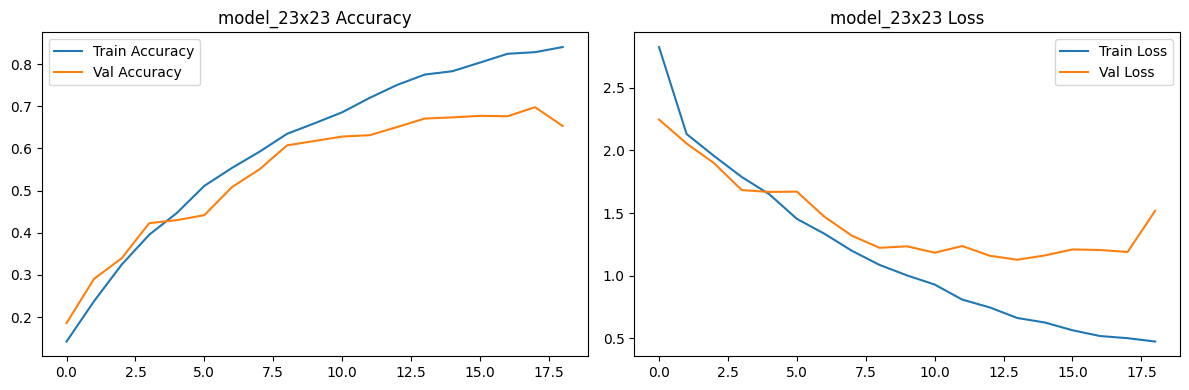

In [12]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 6s 22ms/step - loss: 4.3588 - accuracy: 0.2433 - val_loss: 2.1363 - val_accuracy: 0.2895
Epoch 2/50
241/241 [==============================] - 5s 21ms/step - loss: 1.8316 - accuracy: 0.3965 - val_loss: 1.8188 - val_accuracy: 0.4114
Epoch 3/50
241/241 [==============================] - 5s 21ms/step - loss: 1.4602 - accuracy: 0.5240 - val_loss: 1.7163 - val_accuracy: 0.4664
Epoch 4/50
241/241 [==============================] - 5s 20ms/step - loss: 1.1608 - accuracy: 0.6245 - val_loss: 1.7875 - val_accuracy: 0.4591
Epoch 5/50
241/241 [==============================] - 5s 21ms/step - loss: 0.9489 - accuracy: 0.6850 - val_loss: 1.9001 - val_accuracy: 0.5064
Epoch 6/50
241/241 [==============================] - 5s 21ms/step - loss: 0.7910 - accuracy: 0.7357 - val_loss: 1.9748 - val_accuracy: 0.5127
Epoch 7/50
241/241 [==============================] - 5s 20ms/step - loss: 0.6926 - accuracy: 0.7719 - val_loss: 1.

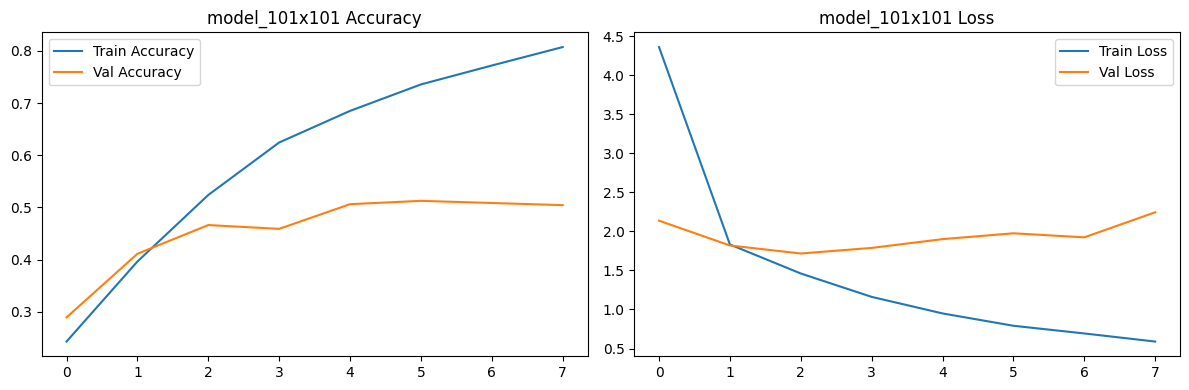

In [13]:
print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

In [14]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy


# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.3732
Test Accuracy: 0.6441
Error Rate: 0.3559

Evaluating 101x101 Model:
Test Loss: 2.2450
Test Accuracy: 0.4886
Error Rate: 0.5114

Accuracy Improvement: -0.1555
Loss Reduction: -0.8719


## Improving the CNN Models

In [15]:
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [16]:
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}_improved.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model



Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 5s 20ms/step - loss: 1.8309 - accuracy: 0.3769 - val_loss: 2.0027 - val_accuracy: 0.3323
Epoch 2/50
241/241 [==============================] - 5s 19ms/step - loss: 1.2632 - accuracy: 0.5825 - val_loss: 1.4718 - val_accuracy: 0.5409
Epoch 3/50
241/241 [==============================] - 5s 19ms/step - loss: 0.9701 - accuracy: 0.6824 - val_loss: 0.9929 - val_accuracy: 0.6577
Epoch 4/50
241/241 [==============================] - 5s 19ms/step - loss: 0.7612 - accuracy: 0.7523 - val_loss: 0.9843 - val_accuracy: 0.6745
Epoch 5/50
241/241 [==============================] - 5s 19ms/step - loss: 0.6188 - accuracy: 0.7941 - val_loss: 0.9880 - val_accuracy: 0.6914
Epoch 6/50
241/241 [==============================] - 5s 19ms/step - loss: 0.5156 - accuracy: 0.8300 - val_loss: 1.6878 - val_accuracy: 0.5359
Epoch 7/50
241/241 [==============================] - 5s 19ms/step - loss: 0.4407 - accuracy: 0.8523

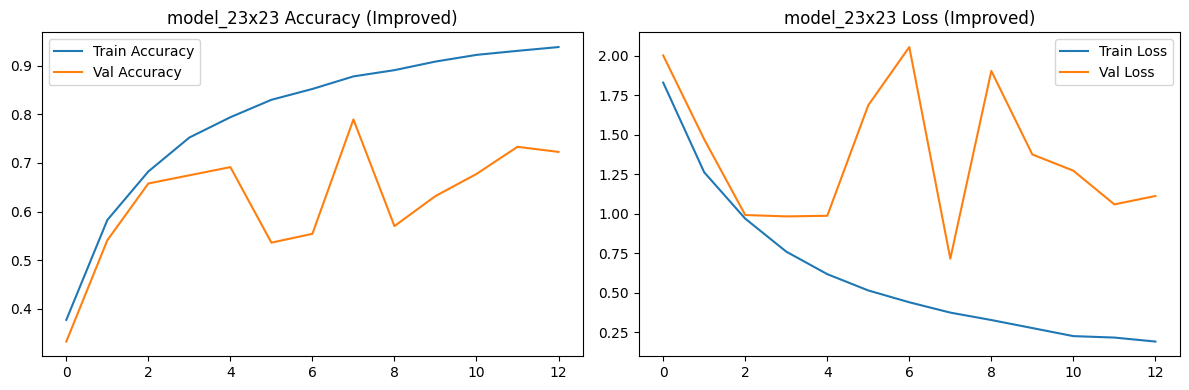


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 6s 23ms/step - loss: 1.6084 - accuracy: 0.4610 - val_loss: 1.7396 - val_accuracy: 0.4132
Epoch 2/50
241/241 [==============================] - 6s 23ms/step - loss: 0.9919 - accuracy: 0.6762 - val_loss: 2.3956 - val_accuracy: 0.4677
Epoch 3/50
241/241 [==============================] - 5s 22ms/step - loss: 0.6868 - accuracy: 0.7844 - val_loss: 1.2400 - val_accuracy: 0.6491
Epoch 4/50
241/241 [==============================] - 5s 22ms/step - loss: 0.5155 - accuracy: 0.8386 - val_loss: 2.2849 - val_accuracy: 0.4805
Epoch 5/50
241/241 [==============================] - 5s 22ms/step - loss: 0.3993 - accuracy: 0.8758 - val_loss: 2.1915 - val_accuracy: 0.5764
Epoch 6/50
241/241 [==============================] - 5s 22ms/step - loss: 0.3509 - accuracy: 0.8928 - val_loss: 1.4619 - val_accuracy: 0.6036
Epoch 7/50
241/241 [==============================] - 5s 22ms/step - loss: 0.2957 - accuracy: 0.90

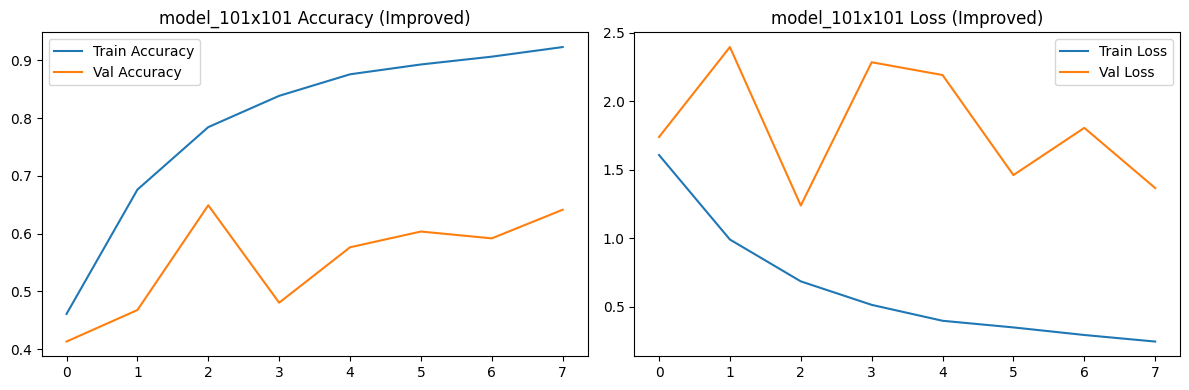

In [17]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")

In [18]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy


# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")



Evaluating 23x23 Model (Improved):
Test Loss: 0.7370
Test Accuracy: 0.7741
Error Rate: 0.2259

Evaluating 101x101 Model (Improved):
Test Loss: 1.2666
Test Accuracy: 0.6459
Error Rate: 0.3541

Accuracy Improvement (101x101 - 23x23): -0.1282
Loss Reduction (23x23 - 101x101): -0.5297


## Implement Hyperparameter Tuning for the 23x23 Model

In [19]:
import keras_tuner as kt

# Define the model-building function for Keras Tuner
def build_23_model_with_hyperparameters(hp):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_23_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_23_model_tuning'
)

In [21]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Trial 50 Complete [00h 00m 43s]
val_accuracy: 0.7836363911628723

Best val_accuracy So Far: 0.8531818389892578
Total elapsed time: 01h 36m 00s
Best Hyperparameters: {'conv_1_filters': 64, 'conv_2_filters': 192, 'conv_3_filters': 384, 'dense_units': 384, 'dropout_rate': 0.5, 'learning_rate': 0.00028745791047186465}


In [ ]:
# Build and train the model with the best hyperparameters
best_23_model = tuner.hypermodel.build(best_hps)
history = best_23_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)


Epoch 1/50
241/241 [==============================] - 5s 19ms/step - loss: 1.6894 - accuracy: 0.4428 - val_loss: 1.4449 - val_accuracy: 0.5195
Epoch 2/50
241/241 [==============================] - 5s 19ms/step - loss: 1.0168 - accuracy: 0.6665 - val_loss: 0.8861 - val_accuracy: 0.7136
Epoch 3/50
241/241 [==============================] - 4s 18ms/step - loss: 0.6774 - accuracy: 0.7857 - val_loss: 0.8640 - val_accuracy: 0.7173
Epoch 4/50
241/241 [==============================] - 4s 18ms/step - loss: 0.4546 - accuracy: 0.8595 - val_loss: 0.9372 - val_accuracy: 0.7123
Epoch 5/50
241/241 [==============================] - 4s 18ms/step - loss: 0.3081 - accuracy: 0.9078 - val_loss: 0.5250 - val_accuracy: 0.8341
Epoch 6/50
241/241 [==============================] - 4s 18ms/step - loss: 0.2047 - accuracy: 0.9418 - val_loss: 0.5447 - val_accuracy: 0.8291
Epoch 7/50
241/241 [==============================] - 4s 18ms/step - loss: 0.1438 - accuracy: 0.9603 - val_loss: 0.5112 - val_accuracy: 0.8418

In [23]:
# Evaluate the best model
test_loss, test_acc = best_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


69/69 [==============================] - 2s 20ms/step - loss: 1.0853 - accuracy: 0.7359
Test Accuracy: 0.7359
Test Loss: 1.0853


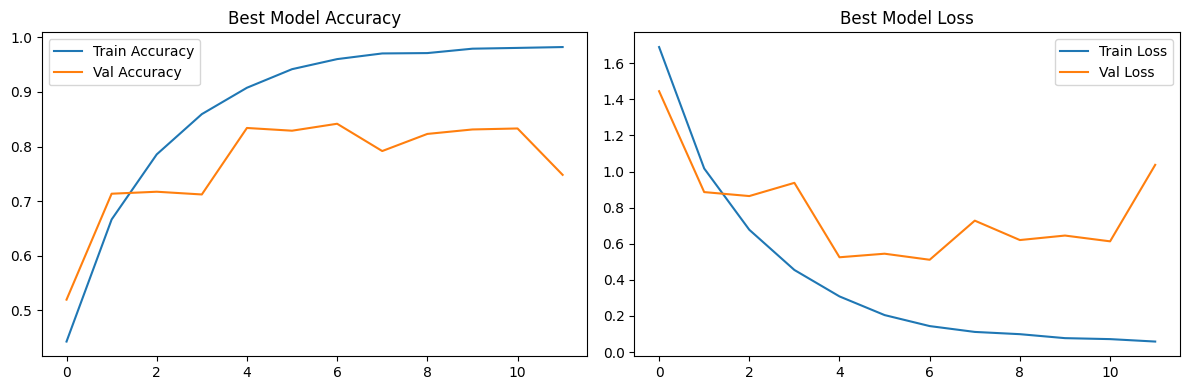

In [24]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title(f"Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"Best Model Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Implement Hyperparameter Tuning for the 101x101 Model

In [29]:
# Define the model-building function for Keras Tuner
def build_101_model_with_hyperparameters(hp):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(101, 101, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_101_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=50,
    directory='kt_dir',
    project_name='improved_101_model_tuning'
)

Reloading Tuner from kt_dir\improved_101_model_tuning\tuner0.json


In [30]:
# Run hyperparameter tuning
tuner.search(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Trial 7 Complete [00h 02m 45s]
val_accuracy: 0.9545454382896423

Best val_accuracy So Far: 0.964090883731842
Total elapsed time: 00h 15m 45s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
96                |32                |conv_1_filters
128               |128               |conv_2_filters
512               |512               |conv_3_filters
448               |512               |dense_units
0.3               |0.5               |dropout_rate
1.89e-05          |0.0015706         |learning_rate

Epoch 1/50
241/241 [==============================] - 8s 29ms/step - loss: 1.9237 - accuracy: 0.3651 - val_loss: 1.9169 - val_accuracy: 0.3268
Epoch 2/50
241/241 [==============================] - 7s 27ms/step - loss: 1.5641 - accuracy: 0.5031 - val_loss: 1.5076 - val_accuracy: 0.5114
Epoch 3/50
241/241 [==============================] - 7s 27ms/step - loss: 1.3581 - accuracy: 0.5745 - val_loss: 1.3120 - val_accuracy: 0.5718
Epoch 4/50
241/241 [=================

KeyboardInterrupt: 

In [ ]:
# Build and train the model with the best hyperparameters
best_101_model = tuner.hypermodel.build(best_hps)
history = best_101_model.fit(
    train_101,  # Training dataset
    validation_data=val_101,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)
